In [6]:
from astropy.io import fits
import numpy as np
import scipy
import scipy.ndimage as scipynd
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from numba import jit

# chi$^2$ fitting of synthetic spectra to spectra of NGC 7006

In [144]:
# load in data
def loadFits(file):
    hdu = fits.open(file)
    return hdu
    
file = 'spec1d_DE.20110603.45055-n7006a_DEIMOS_2011Jun03T123053.021.fits'
hdu = loadFits(file)
starID = [121, 135, 157]

star ID 121


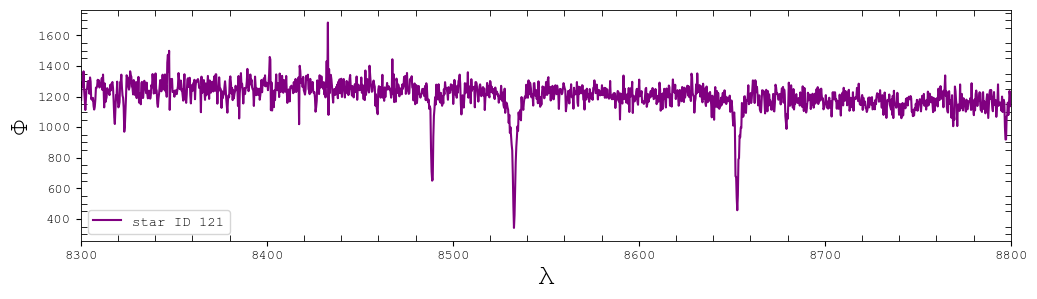

star ID 135


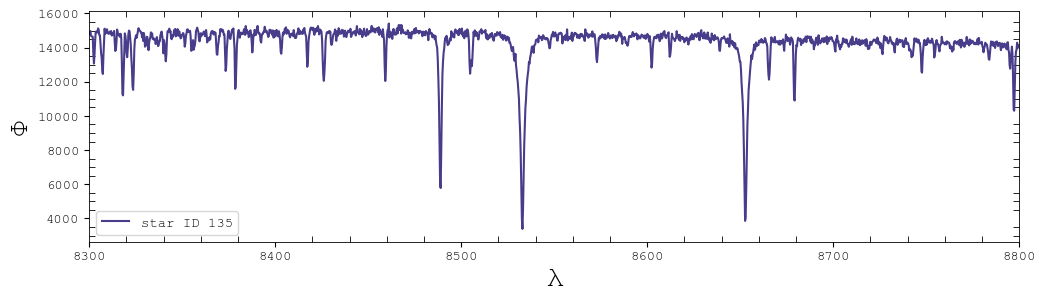

star ID 157


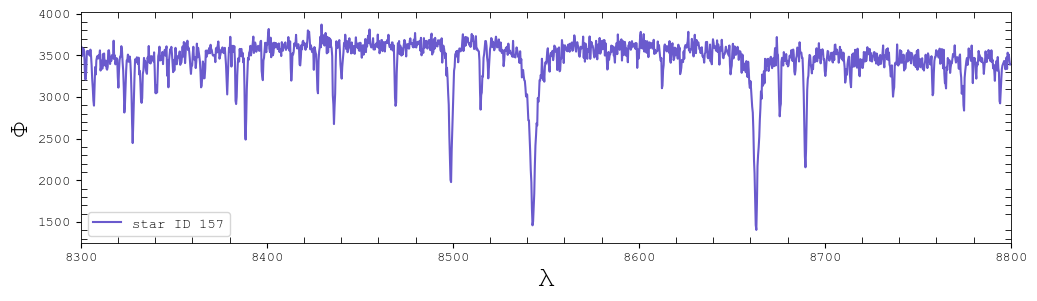

In [141]:
# For each of these three stars, plot the wavelength versus counts.  Use ylim =  8300-8800 Angstrum
SPAT121, SPAT135, SPAT157 = hdu[121], hdu[135], hdu[157]
def getData(Data):
    '''function that returns wavelengths, counts, and inverse variance for a given star'''
    mask = (Data.data['OPT_WAVE'] > 8300) & (Data.data['OPT_WAVE'] < 8800)
    return Data.data['OPT_WAVE'][mask], Data.data['OPT_COUNTS'][mask], Data.data['OPT_COUNTS_IVAR'][mask]

def plotSpectra(wavelength, flux, label = '', model = False, alpha = 1, c = 2, lines = False):
    '''function for plotting spectra and synthetic model spectra'''
    colors = ['purple', 'darkslateblue', 'palevioletred']
    color = colors[0]
    if label == 'star ID 135':
        color = 'darkslateblue'
    if label == 'star ID 157':
        color = 'slateblue'
    plt.figure(figsize = (12,3))
    plt.rcParams['font.family'] = 'courier new'
    plt.minorticks_on()
    plt.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    plt.plot(wavelength, flux, label = label, c = color, alpha = alpha)
    if model != False:
        plt.plot(model[0], model[1], lw = 1.5, color = colors[c], label = 'model spectrum')
    plt.xlim(8300, 8800)
    mask = (wavelength > 8300) & (wavelength < 8800)
    diff = np.max(flux[mask]) - np.min(flux[mask])
    plt.ylim(np.min(flux[mask])-diff/16, np.max(flux[mask])+diff/16)
    if lines == True:
        plt.axvline(x = 8652.8, color = 'black', ls = 'dashed', lw = 1, alpha = .5)
        plt.axvline(x = 8532.9, color = 'black', ls = 'dashed', lw = 1, alpha = .5)
        plt.axvline(x = 8489, color = 'black', ls = 'dashed', lw = 1, alpha = .5)
        plt.text(8657, np.max(flux[mask])-diff/22, 'Ca II', fontsize = 10, fontname = 'courier new')
    plt.xlabel('\u03BB', size = 20)
    plt.ylabel('Φ', size = 20)
    plt.legend(loc = 'lower left')
    plt.show()
    return None

# plot raw spectra
for ID in starID:
    print('star ID {}'.format(ID))
    # load star spectrum
    sciWave, sciFlux, sciVar = getData(hdu[ID])
    plotSpectra(sciWave, sciFlux, 'star ID {}'.format(ID))

## read in synthetic spectrum

In [142]:
syntheticSpecFile = 'dmost_lte_5500_3.0_-1.0_.fits'
def read_synthetic_spectrum(pfile):
    '''
    Function to load synthetic template file into python using vacuum wavelengths
    '''
    with fits.open(pfile) as hdu:
        data     = hdu[1].data   
    synFlux = np.array(data['flux']).flatten()
    awave = np.exp((data['wave']).flatten())
    # CONVERTING AIR WAVELENGTHS TO VACUUM
    s = 10**4 / awave
    n = 1. + 0.00008336624212083 + \
            (0.02408926869968 / (130.1065924522 - s**2)) +\
            (0.0001599740894897 / (38.92568793293 - s**2))

    synWave  = awave*n
    return synWave, synFlux

# read in synthetic spectra and smooth flux
synWave, synFlux = read_synthetic_spectrum(syntheticSpecFile)
synFluxS = scipynd.gaussian_filter1d(synFlux, 25, truncate=3)

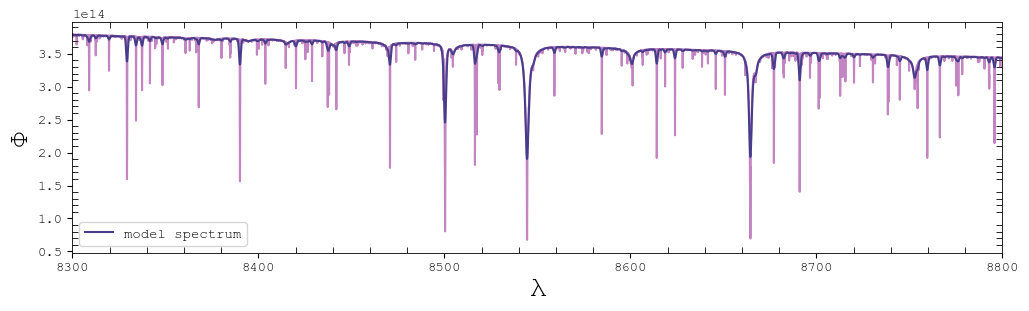

In [143]:
plotSpectra(synWave, synFlux, model = [synWave, synFluxS], alpha = 0.48, c = 1)

star ID 121


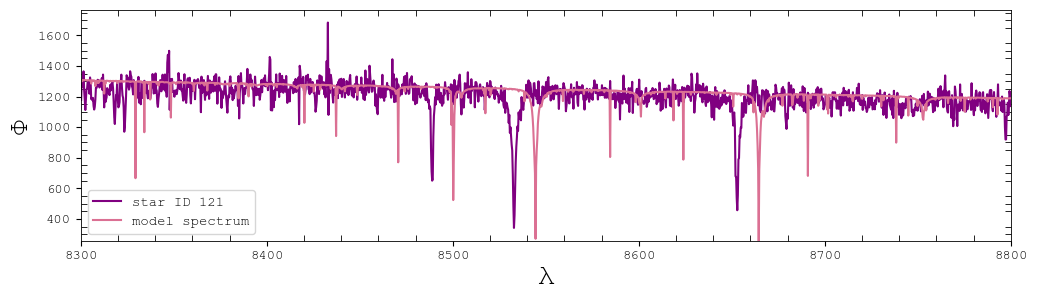

star ID 135


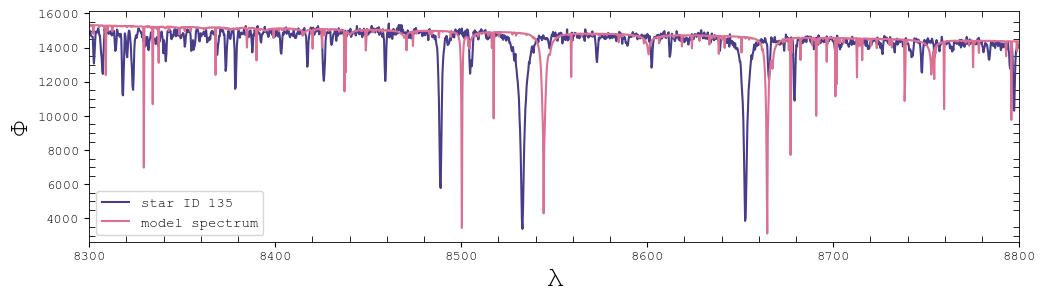

star ID 157


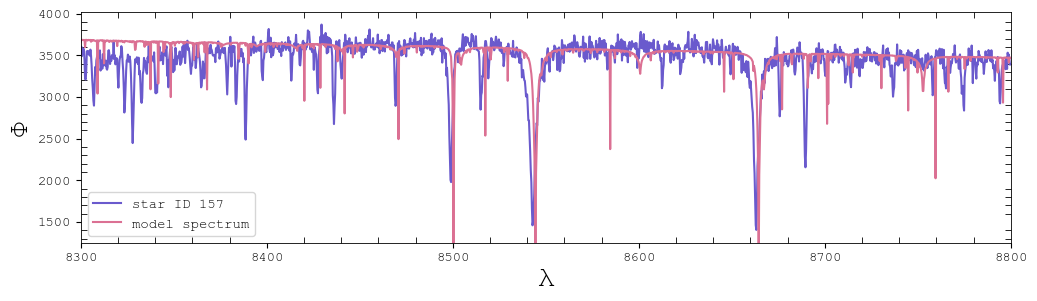

In [145]:
def matchContinuum(synWave, synFlux, sciWav, sciFlux):
    # interpolate synthetic spectrum to science wavelengths
    interpFlux = np.interp(sciWav, synWave, synFlux)
    # mask out deepest lines
    continuum = sciFlux/interpFlux
    mask = (continuum > np.percentile(continuum, 20)) & (continuum < np.percentile(continuum, 99))
    # compute transformation to fit synthetic spectrum continuum onto science
    poly = np.polyfit(sciWav[mask], sciFlux[mask]/interpFlux[mask], 1)
    transform = np.poly1d(poly)
    return interpFlux * transform(sciWav)

# plot raw spectra
for ID in starID:
    print('star ID {}'.format(ID))
    # load star spectrum
    sciWave, sciFlux, sciVar = getData(hdu[ID])
    model = matchContinuum(synWave, synFlux, sciWave, sciFlux)
    plotSpectra(sciWave, sciFlux, 'star ID {}'.format(ID), model = [sciWave, model])


## one parameter chi$^2$

star ID 121


100%|███████████████████████████████████████| 1200/1200 [00:12<00:00, 97.91it/s]


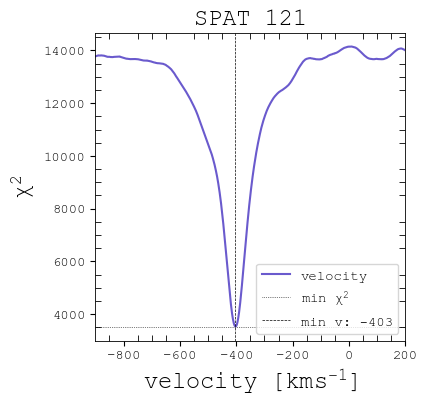

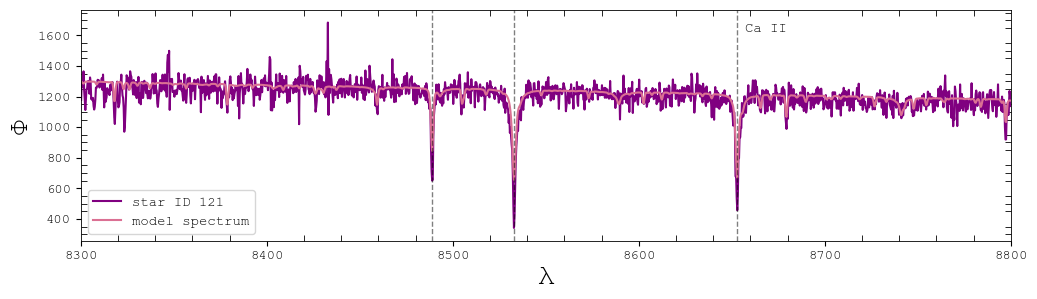

star ID 135


100%|███████████████████████████████████████| 1200/1200 [00:12<00:00, 98.53it/s]


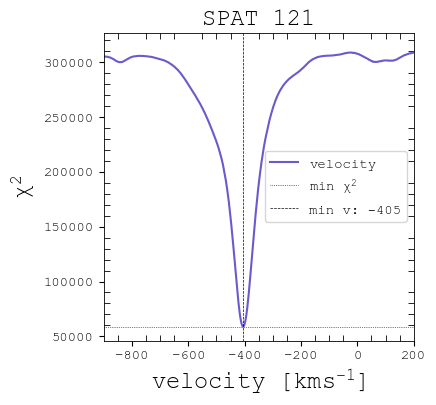

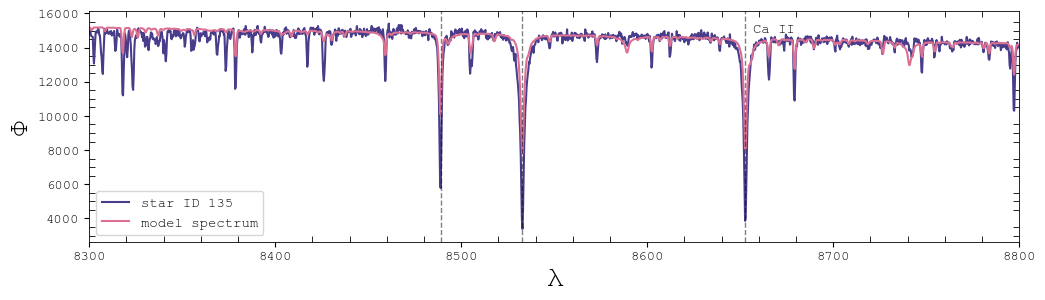

star ID 157


100%|███████████████████████████████████████| 1200/1200 [00:12<00:00, 97.19it/s]


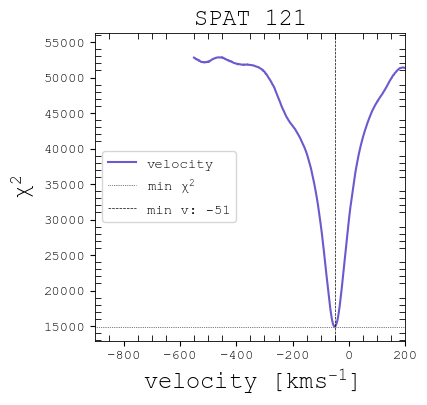

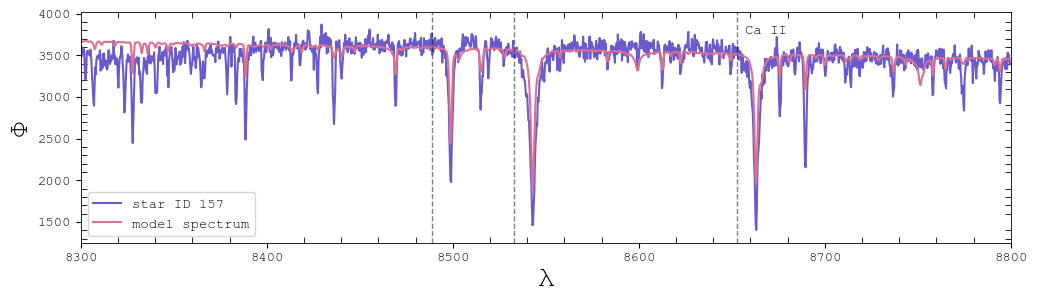

In [126]:
starID = [121, 135, 157]
velGuess = [-400, -400, -50]
# loop through each star
for ID, vGuess in zip(starID, velGuess):
    print('star ID {}'.format(ID))
    # load star spectrum
    sciWave, sciFlux, sciVar = getData(hdu[ID])
    # shift velocity grid by initial guess
    velGrid = np.arange(-500, 700, 1) + vGuess
    # data storing arrays
    chi2Grid, velArr = [],[]
    ###################
    # chi2 minimization
    ###################
    for v in tqdm(velGrid):
        # shift synthetic wavelengths by velocity
        shiftedWave = synWave * (1 + v/2.997924e5) 
        # smooth synthetic fluxes
        synFluxS = scipynd.gaussian_filter1d(synFlux, 25, truncate = 3)
        # transform continuum
        model = matchContinuum(shiftedWave, synFluxS, sciWave, sciFlux)
        # compute chi2
        chi2 = np.sum( sciVar * (sciFlux - model)**2 )
        # save data to arrays
        chi2Grid = np.append(chi2Grid, chi2)
        velArr = np.append(velArr, v)
    # compute minimum chi2, velocity, and smoothing
    idxMin = np.argmin(chi2Grid)
    chi2Min = chi2Grid[idxMin]
    velMin = velArr[idxMin]
    #chi2Grid = chi2Grid.reshape(velGrid.shape[0], smoothGrid.shape[0])
    # plot chi2 v velocity plot
    fig, ax = plt.subplots(figsize = (4, 4))
    plt.rcParams['font.family'] = 'courier new'
    plt.rcParams['mathtext.default'] = 'regular'
    ax.minorticks_on()
    ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    plt.rcParams['axes.linewidth'] = 0.6
    plt.plot(velGrid, chi2Grid, color = 'slateblue', label = 'velocity')
    plt.axhline(y = chi2Min, color = 'black', lw = 0.5, ls = 'dotted', label = r'min $\chi^{2}$')
    plt.axvline(x = velMin, color = 'black', ls = 'dashed', lw = 0.5, label = 'min v: {:.0f}'.format(velMin))
    plt.title('SPAT 121', size = 17)
    plt.xlabel(r'velocity $[km s^{-1}]$', size = 17)
    plt.ylabel(r'$\chi^{2}$', size = 17)
    plt.xlim(-900, 200)
    a = plt.legend(loc = 'best', prop = {'family': 'courier new', 'size': 10})
    #################################################
    # use chi2 parameters to shift synthetic spectrum
    #################################################
    # shift synthetic spectrum by best fit velocity
    shiftedWave = synWave * (1 + velMin/2.997924e5)
    # smooth synthetic spectrum by best fit smoothing kernel
    synFluxS = scipynd.gaussian_filter1d(synFlux, 25, truncate = 3)
    # transform continuum
    model = matchContinuum(shiftedWave, synFluxS, sciWave, sciFlux)
    # plot spectra and model
    plotSpectra(sciWave, sciFlux, label = 'star ID {}'.format(ID), model = [sciWave, model], alpha = 1, c = 2, lines = True)

## two parameter chi$^2$

star ID 121


100%|███████████████████████████████████████████| 30/30 [00:53<00:00,  1.79s/it]


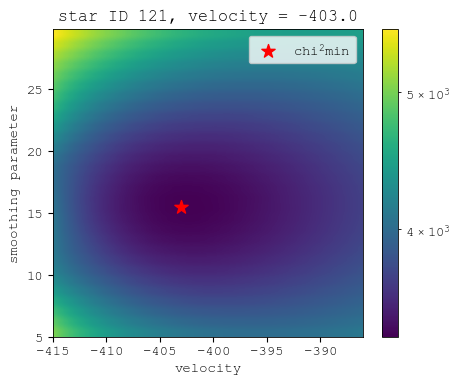

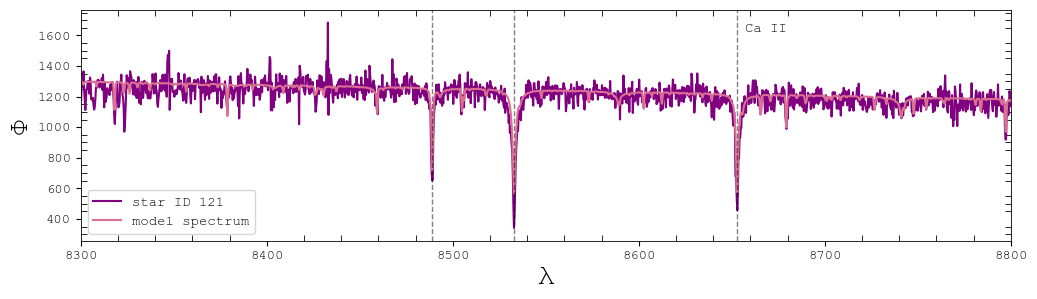

star ID 135


100%|███████████████████████████████████████████| 30/30 [00:54<00:00,  1.81s/it]


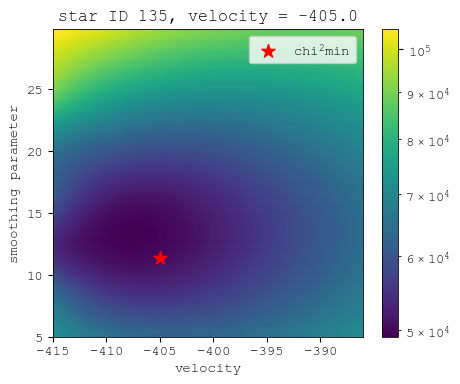

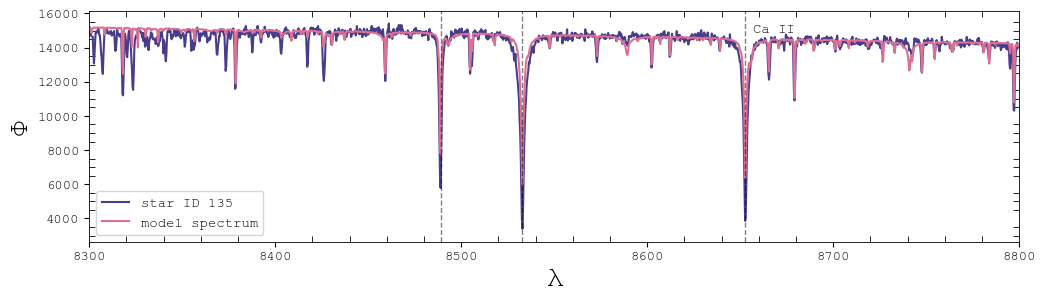

star ID 157


100%|███████████████████████████████████████████| 30/30 [00:53<00:00,  1.79s/it]


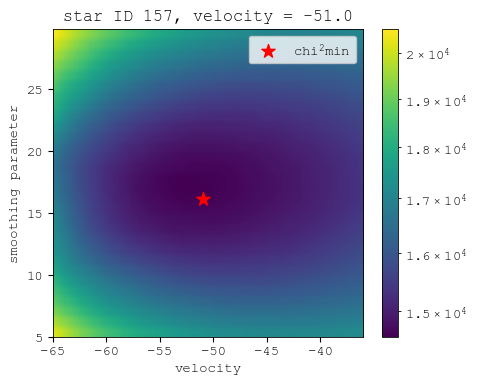

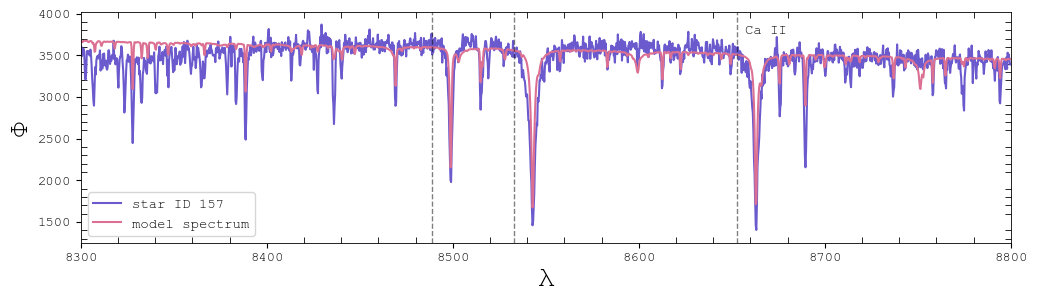

In [130]:
starID = [121, 135, 157]
velGuess = [-400, -400, -50]
smoothGrid = np.arange(5, 30, 0.1)
# loop through each star
for ID, vGuess in zip(starID, velGuess):
    print('star ID {}'.format(ID))
    # load star spectrum
    sciWave, sciFlux, sciVar = getData(hdu[ID])
    # shift velocity grid by initial guess
    velGrid = np.arange(-15, 15, 1) + vGuess
    extent = (np.min(velGrid), np.max(velGrid), np.min(smoothGrid), np.max(smoothGrid))
    # data storing arrays
    chi2Grid, velArr, smoothArr = [],[],[]
    ###################
    # chi2 minimization
    ###################
    for v in tqdm(velGrid):
        for s in smoothGrid:
            # shift synthetic wavelengths by velocity
            shiftedWave = synWave * (1 + v/2.997924e5) 
            # smooth synthetic fluxes
            synFluxS = scipynd.gaussian_filter1d(synFlux, s, truncate = 3)
            # transform continuum
            model = matchContinuum(shiftedWave, synFluxS, sciWave, sciFlux)
            # compute chi2
            chi2 = np.sum( sciVar * (sciFlux - model)**2 )
            # save data to arrays
            chi2Grid = np.append(chi2Grid, chi2)
            velArr = np.append(velArr, v)
            smoothArr = np.append(smoothArr, s)
    # compute minimum chi2, velocity, and smoothing
    idxMin = np.argmin(chi2Grid)
    chi2Min = chi2Grid[idxMin]
    velMin = velArr[idxMin]
    smoothMin = smoothArr[idxMin]
    chi2Grid = chi2Grid.reshape(velGrid.shape[0], smoothGrid.shape[0])
    # plot chi2 heat map
    plt.figure(figsize = (5,4))
    plt.rcParams['font.family'] = 'courier new'
    plt.rcParams['mathtext.default'] = 'regular'
    plt.imshow(chi2Grid, aspect = 'auto', norm = LogNorm(), extent = extent, origin = 'lower')
    plt.colorbar()
    plt.scatter(velMin, smoothMin, marker = '*', c = 'r', s = 100, label = '$chi^2 min$')
    plt.title('star ID {}, velocity = {}'.format(ID, velMin))
    plt.xlabel('velocity')
    plt.ylabel('smoothing parameter')
    plt.legend()
    plt.show()
    # -----------------------------------------------
    # use chi2 parameters to shift synthetic spectrum
    # shift synthetic spectrum by best fit velocity
    shiftedWave = synWave * (1 + velMin/2.997924e5)
    # smooth synthetic spectrum by best fit smoothing kernel
    synFluxS = scipynd.gaussian_filter1d(synFlux, smoothMin, truncate = 3)
    # transform continuum
    model = matchContinuum(shiftedWave, synFluxS, sciWave, sciFlux)
    # plot spectra and model
    plotSpectra(sciWave, sciFlux, label = 'star ID {}'.format(ID), model = [sciWave, model], alpha = 1, c = 2, lines = True)